<a href="https://colab.research.google.com/github/CorneliusPS/absa-bert/blob/main/BERT_ABSA_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Environment

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


## Import Library Yang Dibutuhkan

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Scrapping data from Google Play Store

In [ ]:
!pip install -q google-play-scraper
from google_play_scraper import Sort, reviews

result, continuation_token = reviews(
    "id.dana",
    lang='id',
    country='id',
    sort= Sort.MOST_RELEVANT,
    count=3500,
    filter_score_with=None
)

In [ ]:
df = pd.DataFrame(np.array(result),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df.rename(columns = {'content':'review_text'}, inplace = True)
df[["review_text"]].to_csv('data_reviews.csv', index=None, header=True)


In [ ]:
df = pd.read_csv("data_reviews.csv")

In [ ]:
df.head(10)

#Text Pre-Processing

##Membaca Data Yang telah di Scrapping

In [ ]:
df = pd.read_csv("data_reviews.csv")

In [ ]:
df

,review_text
0,Kenapa gak bisa belanja di indomart. Kalah sam...
1,Sering error terus knpa ya. Lag terus mau scan...
2,"Saya sangat kecewa dengan dana, harga lebih ma..."
3,sangat membatu& biaya pengiriman sangat minim👍👍
4,"Saran,kalau harga pulsa dan paket data tlng ha..."
...,...
3495,"pembaruan bukan nya bagus malah jelek, selama ..."
3496,"gimana cara makenya , maksa banget buat ngasih..."
3497,Apk dana bagus cuman ada yg kurang kalo bisa a...
3498,Jangan mudah percaya sama promonya.kirim uang ...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Filtering

In [ ]:
def filtering(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)

    # Hapus karakter non-alphabetic kecuali spasi
    text = re.sub(r'[^a-zA-Z ]', ' ', text)

    #hapus tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))

    #hapus spasi tambahan dan spasi putih
    text = text.strip()

    #ubah spasi putih yang banyak  menjadi satu spasi putih

    text = re.sub('\s+', ' ', text)

    #hapus single karakter
    text = re.sub(r"\b[a-zA-Z]\b", "", text)

    return text

# Pre-process the text data
df['filtering'] = df['review_text'].apply(filtering)

In [ ]:
df.sample(10)

,review_text,filtering,case_folding
749,"Aplikasi nya si bagus, HANYA YANG JELEK PELAYA...",Aplikasi nya si bagus HANYA YANG JELEK PELAYAN...,aplikasi nya si bagus hanya yang jelek pelayan...
3294,"Stiap login ulang, tidak bisa masuk karna terl...",Stiap login ulang tidak bisa masuk karna terla...,stiap login ulang tidak bisa masuk karna terla...
852,"Sistem apa ini, yakali saya mau transfer 90% d...",Sistem apa ini yakali saya mau transfer dari s...,sistem apa ini yakali saya mau transfer dari s...
1969,"Sering eror jadi gk nyaman makai dana,tolong d...",Sering eror jadi gk nyaman makai dana tolong d...,sering eror jadi gk nyaman makai dana tolong d...
3273,tetap amanah dan tingkatkan kualitas serta fit...,tetap amanah dan tingkatkan kualitas serta fit...,tetap amanah dan tingkatkan kualitas serta fit...
3196,"Suka dengan Aplikasi ini, semoga selalu ada pe...",Suka dengan Aplikasi ini semoga selalu ada pen...,suka dengan aplikasi ini semoga selalu ada pen...
2292,Maaf sebelumnya saya kan main game mah dapat u...,Maaf sebelumnya saya kan main game mah dapat u...,maaf sebelumnya saya kan main game mah dapat u...
2233,Kenapa saya tidak bisa login dan aplikasi upda...,Kenapa saya tidak bisa login dan aplikasi upda...,kenapa saya tidak bisa login dan aplikasi upda...
2760,"Ini aplikasi sudah di updata, tolong di terjem...",Ini aplikasi sudah di updata tolong di terjema...,ini aplikasi sudah di updata tolong di terjema...
1009,"Jangan keseringan update , setiap x buka app l...",Jangan keseringan update setiap buka app load...,jangan keseringan update setiap buka app load...


## Case Folding

In [ ]:
# Case Folding
df['case_folding'] = df['filtering'].str.lower()

In [ ]:
df[['case_folding']].sample(10)

,case_folding
3481,sudah bagus cuma kurang setuju dengan adanya a...
242,gak jelas ni aplikasi udh coba daftar premium ...
2210,halo admin untuk transaksi sebelum bulan april...
193,makin lemot sering error isi saldo pake qrcode...
2961,sangat mudah dan simple untuk semua transaksi ...
1008,agak kecewa sama servernya sinyal sudah lumaya...
1818,aplikasi dana sudah di update tapi malah ada p...
607,sangat kecewe dikarenakan tidak bisa upgrade k...
942,kenapa aplikasi saya ngak bisa log in keterang...
3140,simpel gak ribet banyak diskon dan aman mantap...


## Tokenizing

In [ ]:
# tokenisasi kata menggunakan NLTK
def tokenize_word_wrapper(text):
    return word_tokenize(text)

df['tokenize'] = df['case_folding'].apply(tokenize_word_wrapper)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df[['tokenize']].sample(10)

,tokenize
2202,"[pen, jadiin, dana, sebagai, aplikasi, menabun..."
3237,"[makin, lama, apk, ini, makin, susah, di, guna..."
3326,"[mau, kirim, uang, dari, dana, ke, rekening, s..."
2633,"[mohon, maaf, sistem, tidak, dapat, menampilka..."
3396,"[sangat, membantu, dan, banyak, promo, pertaha..."
2723,"[bnr, membantu, mengelola, keuangan, ad, menu,..."
2234,"[versi, yang, ini, malah, sering, nge, bug, be..."
1940,"[tolong, kok, waktu, log, in, gak, bisa, dikar..."
198,"[aplikasi, bobrok, gw, mau, tf, aja, sampe, nu..."
3007,"[puas, bingit, meski, sedikit, sering, mengala..."


## Stopwords Removal

In [ ]:
# menggunakan stopwords bahasa indonesia
stopwords_indonesia = set(stopwords.words('indonesian'))

# menambahkan stopwords tambahan
additional_list_of_stopwords = ['nya', 'amp','elor','huhuhu','hm','uy','daba','hmm','hmmm' 'nan', 'u', 'tuh', 'kalo', 'sih', 'ny', 'jgn', 'ga',
                                'nih', 'jd', 'hehe', 'loh', 'aja','nk','dt','dei', 'biar', 'pen', 'tdk', 'd','yg', 'tau', 'yg', 'klo', 'dg',
                                'bilang','si', 'gak','sliweran','was','jooos','jozz','jm','ddink','li','ysaha' 'yah', 'utk', 'sdh','ya','dana',
                                'kere','saya','ke','mau','di','ini','ysaha','dan','lagi','dari','he','bertan','rah','ca','heee','ol','bula',
                                'hehhehehehe','tololl','joss','wkwk']

stopwords_indonesia.update(additional_list_of_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
    return [word for word in text if word not in stopwords_indonesia]

df['stopword'] = df['tokenize'].apply(remove_stopwords)

In [ ]:
df[['stopword']].sample(10)

,stopword
2046,"[lemot, transaksi, tnpa, notifikasi, aman, tra..."
3379,"[lumyan, aplikasi, gk, ribet, transfer, belanj..."
2658,"[dompet, digital, terpercaya, memuaskan, trans..."
3249,"[bagus, praktis, kadang, tba, tba, gangguan, t..."
309,"[top, up, saldo, transaksi, butuh, upgread, pr..."
669,"[aplikasi, ni, eror, mulu, kemaren, transfer, ..."
3216,"[memuaskan, dlam, pelayanan, semoga, kedepan, ..."
1972,"[login, gimana, aplikasi, update, error]"
22,"[aplikasi, buruk, akun, jaadi, premium, akun, ..."
3172,"[tolong, andmin, responnya, cs, email, percepa..."


## Normalisasi

In [ ]:
# membaca dan menggunakan kamus kata untuk normalisasi
dictionary = "kamus.xlsx"
normalized_word = pd.read_excel(dictionary)


# membuat kamus (dictionary) baru dari dua kolom dalam suatu dataframe (normalized_word)
#normalized_word.iloc[:, 0]  mengambil semua baris pada kolom pertama normalized_word. Normalized_word.iloc[:, 1] mengambil pada kolom kedua
normalized_word_dict = dict(zip(normalized_word.iloc[:, 0], normalized_word.iloc[:, 1]))

# fungsi untuk normalisasi kata dalam sebuah dokumen

def normalize_term(document):
    text = [normalized_word_dict.get(term, term) for term in document]

    return text

# normalisasi kata dalam kolom 'stopwords' di dalam dataframe 'data_twitter'
df['normalize'] = df['stopword'].apply(normalize_term)

In [ ]:
df[['normalize']].sample(5)

,normalize
1791,"[update, versi, ribet, banget, isi, saldo, lan..."
2328,"[tolong, maintenen, harap, hubungi, transperan..."
2273,"[kasih, bintang, bertanya, flip, card, cash, p..."
1674,"[kasih, bintang, pas, lupa, pin, pencet, lupa,..."
3399,"[membuat, bank, kayak, dipinggir, jalan, conto..."


## Menyimpan dataset yang telah dilakukan proses pre-processing

In [ ]:
df.to_csv('data_preprocessing.csv', index=False)

In [ ]:
df.sample(5)

,review_text,filtering,case_folding,tokenize,stopword,normalize
3049,Sangat nyaman menggunakan apk ini transaksi mu...,Sangat nyaman menggunakan apk ini transaksi mu...,sangat nyaman menggunakan apk ini transaksi mu...,"[sangat, nyaman, menggunakan, apk, ini, transa...","[nyaman, apk, transaksi, mudah, cepat]","[nyaman, aplikasi, transaksi, mudah, cepat]"
770,Kenapa dana saya tidak bisa login Padahal suda...,Kenapa dana saya tidak bisa login Padahal suda...,kenapa dana saya tidak bisa login padahal suda...,"[kenapa, dana, saya, tidak, bisa, login, padah...","[login, update, versi, terbaru, gk, login, sur...","[login, update, versi, terbaru, enggak, login,..."
2622,Sebagai pengguna lama secara pribadi aplikasi ...,Sebagai pengguna lama secara pribadi aplikasi ...,sebagai pengguna lama secara pribadi aplikasi ...,"[sebagai, pengguna, lama, secara, pribadi, apl...","[pengguna, pribadi, aplikasi, membantu, menyim...","[pengguna, pribadi, aplikasi, membantu, menyim..."
2469,Knapa ngga mau login lagii?malah keluar dan ma...,Knapa ngga mau login lagii malah keluar dan ma...,knapa ngga mau login lagii malah keluar dan ma...,"[knapa, ngga, mau, login, lagii, malah, keluar...","[knapa, ngga, login, lagii, masukin, nomor, su...","[knapa, enggak, login, lagi, memasuki, nomor, ..."
1989,Ini kenapa aplikasinya nggak bisa login padaha...,Ini kenapa aplikasinya nggak bisa login padaha...,ini kenapa aplikasinya nggak bisa login padaha...,"[ini, kenapa, aplikasinya, nggak, bisa, login,...","[aplikasinya, nggak, login, butuh, banget, uan...","[aplikasinya, enggak, login, butuh, banget, ua..."


#Labeling Sentimen menggunakan Lexicon Based

In [ ]:
lexicon_positive = dict()

import csv

with open('/content/drive/MyDrive/Skripsi/positive.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader) # skip header
  for row in reader:
    lexicon_positive[row[0]] = int (row[1])

lexicon_negative = dict()

with open('/content/drive/MyDrive/Skripsi/negative.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader) # skip header
  for row in reader:
    lexicon_negative[row[0]] = int (row[1])

def labeling_lexicon_indonesia(text):
  score = 0
  for word in text:
    if word in lexicon_positive:
      score += lexicon_positive[word]

  for word in text:
    if word in lexicon_negative:
      score += lexicon_negative[word]

  label = ''
  if score > 0:
    label = '2'
  elif score < 0:
    label = '0'
  else:
    label = '1'
  return score, label

In [ ]:
results = df['normalize'].apply(labeling_lexicon_indonesia)
results = list(zip(*results))
df['sentiment'] = results[1]

In [ ]:
df['sentiment'].value_counts()

0    1892
2    1416
1     192
Name: sentiment, dtype: int64

In [ ]:
df.to_csv('data_sentimen.csv', index=False)

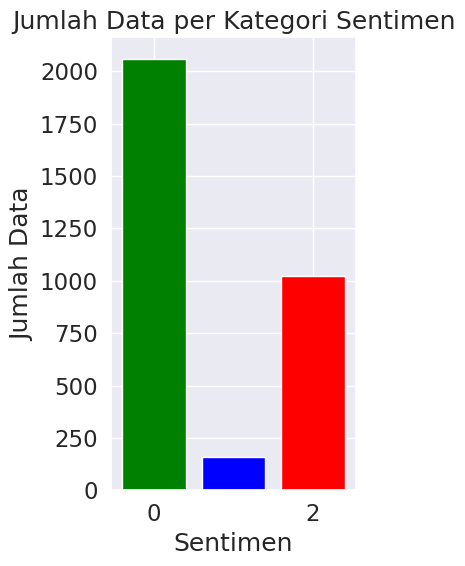

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("data_sentimen.csv")

# Menghitung jumlah data pada setiap kategori sentiment
sentiment_counts = df['sentiment'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(4, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.title('Jumlah Data per Kategori Sentimen')
plt.tight_layout()
plt.show()

#Menggabungkan data token pada kolom normalize untuk persiapkan dataset ke model

In [ ]:
df = pd.read_csv("data_aspek.csv")


In [ ]:
df

,review_text,filtering,case_folding,tokenize,stopword,normalize,sentiment,label
0,Kenapa gak bisa belanja di indomart. Kalah sam...,Kenapa gak bisa belanja di indomart Kalah sama...,kenapa gak bisa belanja di indomart kalah sama...,"['kenapa', 'gak', 'bisa', 'belanja', 'di', 'in...","['belanja', 'indomart', 'kalah', 'linkaja', 't...","['belanja', 'indomart', 'kalah', 'linkaja', 't...",0,['place']
1,Sering error terus knpa ya. Lag terus mau scan...,Sering error terus knpa ya Lag terus mau scan ...,sering error terus knpa ya lag terus mau scan ...,"['sering', 'error', 'terus', 'knpa', 'ya', 'la...","['error', 'knpa', 'lag', 'scan', 'minimal', 'p...","['error', 'kenapa', 'lag', 'scan', 'minimal', ...",0,['place']
2,"Saya sangat kecewa dengan dana, harga lebih ma...",Saya sangat kecewa dengan dana harga lebih mah...,saya sangat kecewa dengan dana harga lebih mah...,"['saya', 'sangat', 'kecewa', 'dengan', 'dana',...","['kecewa', 'harga', 'mahal', 'dompet', 'digital']","['kecewa', 'harga', 'mahal', 'dompet', 'digital']",0,['price']
3,sangat membatu& biaya pengiriman sangat minim👍👍,sangat membatu biaya pengiriman sangat minim,sangat membatu biaya pengiriman sangat minim,"['sangat', 'membatu', 'biaya', 'pengiriman', '...","['membatu', 'biaya', 'pengiriman', 'minim']","['membatu', 'biaya', 'pengiriman', 'minim']",0,['price']
4,"Saran,kalau harga pulsa dan paket data tlng ha...",Saran kalau harga pulsa dan paket data tlng ha...,saran kalau harga pulsa dan paket data tlng ha...,"['saran', 'kalau', 'harga', 'pulsa', 'dan', 'p...","['saran', 'harga', 'pulsa', 'paket', 'data', '...","['saran', 'harga', 'pulsa', 'paket', 'data', '...",0,['price']
...,...,...,...,...,...,...,...,...
3234,"keren tingkatkan terus untuk promo"" nya.aku su...",keren tingkatkan terus untuk promo nya aku suk...,keren tingkatkan terus untuk promo nya aku suk...,"['keren', 'tingkatkan', 'terus', 'untuk', 'pro...","['keren', 'tingkatkan', 'promo', 'suka', 'bang...","['keren', 'tingkatkan', 'promo', 'suka', 'bang...",2,['promotion']
3235,Mantap banyak diskon dan promonya! Keren,Mantap banyak diskon dan promonya Keren,mantap banyak diskon dan promonya keren,"['mantap', 'banyak', 'diskon', 'dan', 'promony...","['mantap', 'diskon', 'promonya', 'keren']","['mantap', 'diskon', 'promonya', 'keren']",2,['promotion']
3236,"Sangat membantu dan banyak promo, pertahankan ...",Sangat membantu dan banyak promo pertahankan k...,sangat membantu dan banyak promo pertahankan k...,"['sangat', 'membantu', 'dan', 'banyak', 'promo...","['membantu', 'promo', 'pertahankan', 'kemantap...","['membantu', 'promo', 'pertahankan', 'kemantap...",2,['promotion']
3237,Sangat membantu.. Semoga ada hadiah nya atau t...,Sangat membantu semoga ada hadiah nya atau tab...,sangat membantu semoga ada hadiah nya atau tab...,"['sangat', 'membantu', 'semoga', 'ada', 'hadia...","['membantu', 'semoga', 'hadiah', 'tabungan', '...","['membantu', 'semoga', 'hadiah', 'tabungan', '...",2,"['promotion', 'product']"


In [ ]:
import ast
# fungsi untuk menggabungkan token-token dari setiap normalize
def join_token_normalize(texts):
    return ' '.join(ast.literal_eval(texts))    # ubah string berformat list menjadi tipe data list yang sesungguhnya

# menggabungkan token-token pada kolom "normalize" dan menambahkan hasilnya ke kolom baru "review_text"
df["review_text"] = df["normalize"].apply(join_token_normalize)

In [ ]:
df = df[['review_text','sentiment','label']]
df.to_csv('data_model.csv', index=False)

In [ ]:
df.to_csv('data_model.csv', index=False)

#Tokenisasi Menggunakan Pre-Train BERT

In [ ]:
df = pd.read_csv("data_model.csv")

df

,review_text,sentiment,label
0,belanja indomart kalah linkaja terkenal kalah ...,0,['place']
1,error kenapa lag scan minimal perbaikan kasih ...,0,['place']
2,kecewa harga mahal dompet digital,0,['price']
3,membatu biaya pengiriman minim,0,['price']
4,saran harga pulsa paket data tlng harganya tur...,0,['price']
...,...,...,...
3234,keren tingkatkan promo suka banget pokok,2,['promotion']
3235,mantap diskon promonya keren,2,['promotion']
3236,membantu promo pertahankan kemantapannya,2,['promotion']
3237,membantu semoga hadiah tabungan top up aplikas...,2,"['promotion', 'product']"


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

#Mendefinisikan tokenizer dari model BERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

#Mendefinisikan Hyperparamter yang akan digunakan pada model
batch_size = 32
learning_rate = 2e-5
eps = 1e-8

In [ ]:
#Test implementasi tokenizer BERT

text = "kebanyakan bug belanja itemku bayarnya pakai pembayarannya mohon bantuannya"

print("Original: ", text)

print("Tokenized: ", tokenizer.tokenize(text))

Original:  kebanyakan bug belanja itemku bayarnya pakai pembayarannya mohon bantuannya
Tokenized:  ['kebanyakan', 'bug', 'belanja', 'item', '##ku', 'bayar', '##nya', 'pakai', 'pembayarannya', 'mohon', 'bantuannya']


In [ ]:
import statistics
sent_length = []

# Untuk mengetahui panjang rata - rata kalimat
for sent in df['review_text']:
    # Menambahkan token spesial token `[CLS]` and `[SEP]`.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  20.242976227230628
Median length =  18


In [ ]:
from transformers import BertTokenizer

# Membuat fungsi untuk melakukan tokenisasi pada teks
def tokenize_text(text, tokenizer):
    tokenized_text = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask = True,
        return_tensors='pt'
    )
    return tokenized_text['input_ids'], tokenized_text['attention_mask']

# Menambahkan kolom "input_ids" dan "attention_mask" sebagai hasil tokenisasi
df['input_ids'], df['attention_mask'] = zip(*df['review_text'].apply(lambda x: tokenize_text(x, tokenizer)))

In [ ]:
print('Original: ', df['review_text'][28])
print('Token IDs:', df['input_ids'][28])

Original:  kebanyakan bug belanja itemku bayarnya pakai pembayarannya mohon bantuannya
Token IDs: tensor([[    2,  3089,  3440,  3866,  6498,   457,  5759,    57,  2468, 23497,
          2903, 12619,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])


#Model Untuk Klasifikasi Sentiment Setiap Aspek

In [ ]:
# Memisahkan data untuk setiap aspek
df_product = df[df['label'].apply(lambda x: 'product' in x)]
df_price = df[df['label'].apply(lambda x: 'price' in x)]
df_place = df[df['label'].apply(lambda x: 'place' in x)]
df_promotion = df[df['label'].apply(lambda x: 'promotion' in x)]

In [ ]:
print('Jumlah Dataset Semula: ', len(df))

print("Sentimen pada aspek product:")
print(df_product["sentiment"].value_counts())
print("Sentimen pada aspek price:")
print(df_price["sentiment"].value_counts())
print("Sentimen pada aspek place:")
print(df_place["sentiment"].value_counts())
print("Sentimen pada aspek promotion:")
print(df_promotion["sentiment"].value_counts())

Jumlah Dataset Semula:  3239
Sentimen pada aspek product:
0    2046
2     987
1     154
Name: sentiment, dtype: int64
Sentimen pada aspek price:
2    125
0     39
1     20
Name: sentiment, dtype: int64
Sentimen pada aspek place:
2    78
0    45
1    23
Name: sentiment, dtype: int64
Sentimen pada aspek promotion:
2    48
0    46
1    17
Name: sentiment, dtype: int64


##Melakukan Klasifikasi Aspek Product

In [ ]:
from sklearn.model_selection import train_test_split

# Split data aspek produk menjadi data train dan data test dengan rasio 80:20
train_df_product, test_df_product = train_test_split(df_product, test_size=0.2)

# Split data test aspek produk menjadi data test dan validation test dengan rasio 50:50
test_df_product, val_df_product = train_test_split(test_df_product, test_size=0.5)

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

# Kolom sentiment yang telah di ubah ke numerik
label = 'sentiment'

# Membuat dataset untuk training aspek product
train_product_input_ids = torch.cat(train_df_product['input_ids'].tolist(), dim=0)
train_product_attention_mask = torch.cat(train_df_product['attention_mask'].tolist(), dim=0)
train_product_sentiment_label = torch.tensor(train_df_product[label].values)

train_product_dataset = TensorDataset(train_product_input_ids, train_product_attention_mask, train_product_sentiment_label)

# Membuat dataset untuk validasi aspek product
val_product_input_ids = torch.cat(val_df_product['input_ids'].tolist(), dim=0)
val_product_attention_mask = torch.cat(val_df_product['attention_mask'].tolist(), dim=0)
val_product_sentimen_label = torch.tensor(val_df_product[label].values)

val_product_dataset = TensorDataset(val_product_input_ids, val_product_attention_mask, val_product_sentimen_label)

In [ ]:
train_product_dataloader = DataLoader(train_product_dataset, sampler=RandomSampler(train_product_dataset), batch_size=batch_size)
val_product_dataloader = DataLoader(val_product_dataset, sampler=SequentialSampler(val_product_dataset), batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Menginisialisasi model BERT Bahasa Indonesia untuk klasifikasi teks
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Menentukan optimizer dan scheduler untuk mengatur learning rate
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

print('Jumlah batch :', len(train_product_dataloader))
total_steps = len(train_product_dataloader) * epochs

# Membuat Learning Rate Schedule Model
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 80


In [ ]:
# Fungsi untuk mengkalkulasikan jumlah akurasi
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
#Fungsi untuk waktu yang digunakan model dalam proses training
def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import random

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    #Training Data
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_product_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_product_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.

        loss = outputs[0]

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_product_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Validation Data
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_product_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_product_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_product_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    20  of     80.    Elapsed: 0:00:09.
  Batch    40  of     80.    Elapsed: 0:00:15.
  Batch    60  of     80.    Elapsed: 0:00:21.

  Average training loss: 0.63
  Training epoch took: 0:00:27

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.62
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    20  of     80.    Elapsed: 0:00:06.
  Batch    40  of     80.    Elapsed: 0:00:13.
  Batch    60  of     80.    Elapsed: 0:00:19.

  Average training loss: 0.47
  Training epoch took: 0:00:25

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.63
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    20  of     80.    Elapsed: 0:00:06.
  Batch    40  of     80.    Elapsed: 0:00:13.
  Batch    60  of     80.    Elapsed: 0:00:19.

  Average training loss: 0.34
  Training epoch took: 0:00:26

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.73
  Validation too

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,0.631555,0.622708,0.739919,0:00:27,0:00:01
2,0.473896,0.633642,0.774294,0:00:25,0:00:01
3,0.336534,0.731633,0.755444,0:00:26,0:00:01
4,0.226096,0.877798,0.758569,0:00:27,0:00:01
5,0.152356,0.940097,0.774194,0:00:27,0:00:01


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []


from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

label = 'sentiment'

# Membuat dataset untuk training
test_product_input_ids = torch.cat(test_df_product['input_ids'].tolist(), dim=0)
test_product_attention_mask = torch.cat(test_df_product['attention_mask'].tolist(), dim=0)
test_product_sentiment_label = torch.tensor(test_df_product[label].values)

batch_size=32

# Create the DataLoader.
prediction_product_data = TensorDataset(test_product_input_ids, test_product_attention_mask, test_product_sentiment_label)
prediction_product_sampler = SequentialSampler(prediction_product_data)
prediction_product_dataloader = DataLoader(prediction_product_data, sampler=prediction_product_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels aspect for {:,} test sentences...'.format(len(test_product_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions_product , true_labels_product = [], []

# Predict
for batch in prediction_product_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions_product
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions_product and true labels
  predictions_product.append(logits)
  true_labels_product.append(label_ids)

print('    DONE.')

Predicting labels aspect for 319 test sentences...
    DONE.


In [ ]:
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions_product)):
  total_accuracy += flat_accuracy(predictions_product[batch_num], true_labels_product[batch_num])

total_accuracy = total_accuracy/len(predictions_product)*100
print('Accuracy on test dataset:', total_accuracy)


Accuracy on test dataset: 80.86693548387096


In [ ]:
from sklearn.metrics import classification_report

# Flatten the predictions_product and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_product for pred in batch_pred]
y_true = [label for batch_label in true_labels_product for label in batch_label]

# Calculate accuracy
total_accuracy = 0
for batch_num in range(len(predictions_product)):
  total_accuracy += flat_accuracy(predictions_product[batch_num], true_labels_product[batch_num])
total_accuracy = total_accuracy/len(predictions_product)*100
print('Accuracy on test dataset aspect product:', total_accuracy)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=['Negatif', 'Netral', 'Positif'])
print('Classification Report Aspect product :\n', report)

Accuracy on test dataset aspect product: 80.86693548387096
Classification Report Aspect product :
               precision    recall  f1-score   support

     Negatif       0.82      0.91      0.87       206
      Netral       0.00      0.00      0.00        13
     Positif       0.78      0.70      0.74       100

    accuracy                           0.81       319
   macro avg       0.53      0.54      0.53       319
weighted avg       0.78      0.81      0.79       319



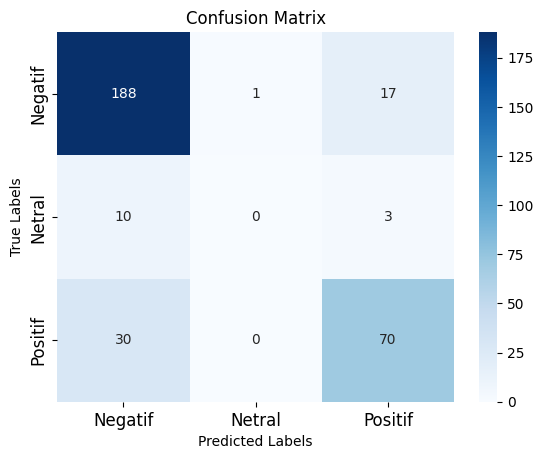

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten the predictions_product and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_product for pred in batch_pred]
y_true = [label for batch_label in true_labels_product for label in batch_label]

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g' )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

ticks = ['Negatif', 'Netral', 'Positif']
plt.xticks([0.5, 1.5, 2.5], ticks, fontsize=12)
plt.yticks([0.5, 1.5, 2.5], ticks, fontsize=12)

plt.show()

##Melakukan Klasifikasi Aspek Price

In [ ]:
from sklearn.model_selection import train_test_split

# Split data aspek price menjadi data train dan data test dengan rasio 80:20
train_df_price, test_df_price = train_test_split(df_price, test_size=0.2, stratify=df_price['sentiment'])

# Split data aspek price menjadi data test dan validation test dengan rasio 50:50
test_df_price, val_df_price = train_test_split(test_df_price, test_size=0.5, stratify=test_df_price['sentiment'])

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

# Kolom sentiment yang telah di ubah ke numerik
label = 'sentiment'

# Membuat dataset untuk training aspek price
train_price_input_ids = torch.cat(train_df_price['input_ids'].tolist(), dim=0)
train_price_attention_mask = torch.cat(train_df_price['attention_mask'].tolist(), dim=0)
train_price_sentiment_label = torch.tensor(train_df_price[label].values)

train_price_dataset = TensorDataset(train_price_input_ids, train_price_attention_mask, train_price_sentiment_label)

# Membuat dataset untuk validasi aspek price
val_price_input_ids = torch.cat(val_df_price['input_ids'].tolist(), dim=0)
val_price_attention_mask = torch.cat(val_df_price['attention_mask'].tolist(), dim=0)
val_price_sentimen_label = torch.tensor(val_df_price[label].values)

val_price_dataset = TensorDataset(val_price_input_ids, val_price_attention_mask, val_price_sentimen_label)

In [ ]:
train_price_dataloader = DataLoader(train_price_dataset, sampler=RandomSampler(train_price_dataset), batch_size=batch_size)
val_price_dataloader = DataLoader(val_price_dataset, sampler=SequentialSampler(val_price_dataset), batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Menginisialisasi model2 BERT Bahasa Indonesia untuk klasifikasi teks
model2 = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Menentukan optimizer dan scheduler untuk mengatur learning rate
optimizer = AdamW(model2.parameters(), lr=learning_rate, eps=eps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_price_dataloader))
total_steps = len(train_price_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 5


In [ ]:
# Fungsi untuk mengkalkulasikan jumlah akurasi
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
#Fungsi untuk waktu yang digunakan model dalam proses training
def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import random
import numpy as np

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    #Training Data
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model2.train()

    # For each batch of training data...
    for step, batch in enumerate(train_price_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_price_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model2.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # token_type_ids is same as the "segment ids", which differentiates
        # sentence 1 and 2 in sentence-pair tasks
        outputs = model2(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.

        loss = outputs[0]

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_price_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Validation Data
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model2.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_price_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model2(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_price_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_price_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.88
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.76
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.70
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.74
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.62
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.73
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.55
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.71
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0:00:02

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.70
  Validation took: 0:00:00

Training complete!


In [ ]:
import pandas as pd


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,0.882029,0.764316,0.684211,0:00:02,0:00:00
2,0.704655,0.744617,0.789474,0:00:02,0:00:00
3,0.624990,0.726028,0.684211,0:00:02,0:00:00
4,0.553257,0.711941,0.736842,0:00:02,0:00:00
5,0.474712,0.703270,0.736842,0:00:02,0:00:00


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

label = 'sentiment'

# Membuat dataset untuk training
test_price_input_ids = torch.cat(test_df_price['input_ids'].tolist(), dim=0)
test_price_attention_mask = torch.cat(test_df_price['attention_mask'].tolist(), dim=0)
test_price_sentiment_label = torch.tensor(test_df_price[label].values)


# Create the DataLoader.
prediction_price_data = TensorDataset(test_price_input_ids, test_price_attention_mask, test_price_sentiment_label)
prediction_price_sampler = SequentialSampler(prediction_price_data)
prediction_price_dataloader = DataLoader(prediction_price_data, sampler=prediction_price_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels aspect for {:,} test sentences...'.format(len(test_price_input_ids)))

# Put model in evaluation mode
model2.eval()

# Tracking variables
predictions_price , true_labels_price = [], []

# Predict
for batch in prediction_price_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions_price
      outputs = model2(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions_price and true labels
  predictions_price.append(logits)
  true_labels_price.append(label_ids)

print('    DONE.')

Predicting labels aspect for 18 test sentences...
    DONE.


In [ ]:
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions_price)):
  total_accuracy += flat_accuracy(predictions_price[batch_num], true_labels_price[batch_num])

total_accuracy = total_accuracy/len(predictions_price)*100
print('Accuracy on test dataset:', total_accuracy)


Accuracy on test dataset: 61.111111111111114


In [ ]:
print(test_df_price['sentiment'].value_counts())

2    12
0     4
1     2
Name: sentiment, dtype: int64


In [ ]:
from sklearn.metrics import classification_report

# Flatten the predictions_price and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_price for pred in batch_pred]
y_true = [label for batch_label in true_labels_price for label in batch_label]

# Calculate accuracy
total_accuracy = 0
for batch_num in range(len(predictions_price)):
  total_accuracy += flat_accuracy(predictions_price[batch_num], true_labels_price[batch_num])
total_accuracy = total_accuracy/len(predictions_price)*100
print('Accuracy on test dataset aspect price:', total_accuracy)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=['Negatif', 'Netral', 'Positif'])
print('Classification Report Aspect price :\n', report)

Accuracy on test dataset aspect price: 61.111111111111114
Classification Report Aspect price :
               precision    recall  f1-score   support

     Negatif       0.25      0.25      0.25         4
      Netral       0.00      0.00      0.00         2
     Positif       0.71      0.83      0.77        12

    accuracy                           0.61        18
   macro avg       0.32      0.36      0.34        18
weighted avg       0.53      0.61      0.57        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


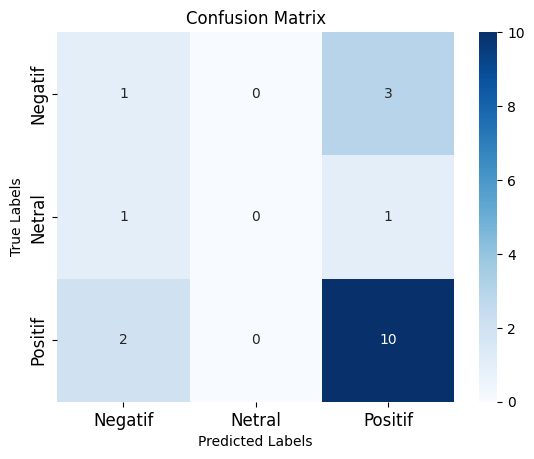

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten the predictions_price and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_price for pred in batch_pred]
y_true = [label for batch_label in true_labels_price for label in batch_label]

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g' )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

ticks = ['Negatif', 'Netral', 'Positif']
plt.xticks([0.5, 1.5, 2.5], ticks, fontsize=12)
plt.yticks([0.5, 1.5, 2.5], ticks, fontsize=12)

plt.show()

##Melakukan Klasifikasi Aspek Place



In [ ]:
from sklearn.model_selection import train_test_split

# Split data menjadi data train dan data test dengan rasio 80:20
train_df_place, test_df_place = train_test_split(df_place, test_size=0.2)

# Split data menjadi data test dan validation test dengan rasio 50:5)
test_df_place, val_df_place = train_test_split(test_df_place, test_size=0.5)

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

# Kolom sentiment yang telah di ubah ke numerik
label = 'sentiment'

# Membuat dataset untuk training aspek place
train_place_input_ids = torch.cat(train_df_place['input_ids'].tolist(), dim=0)
train_place_attention_mask = torch.cat(train_df_place['attention_mask'].tolist(), dim=0)
train_place_sentiment_label = torch.tensor(train_df_place[label].values)

train_place_dataset = TensorDataset(train_place_input_ids, train_place_attention_mask, train_place_sentiment_label)

# Membuat dataset untuk validasi aspek place
val_place_input_ids = torch.cat(val_df_place['input_ids'].tolist(), dim=0)
val_place_attention_mask = torch.cat(val_df_place['attention_mask'].tolist(), dim=0)
val_place_sentimen_label = torch.tensor(val_df_place[label].values)

val_place_dataset = TensorDataset(val_place_input_ids, val_place_attention_mask, val_place_sentimen_label)

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Menginisialisasi model BERT Bahasa Indonesia untuk klasifikasi teks
model3 = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Menentukan optimizer dan scheduler untuk mengatur learning rate
optimizer = AdamW(model3.parameters(), lr=learning_rate, eps=eps)
train_place_dataloader = DataLoader(train_place_dataset, sampler=RandomSampler(train_place_dataset), batch_size=batch_size)
val_place_dataloader = DataLoader(val_place_dataset, sampler=SequentialSampler(val_place_dataset), batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_place_dataloader))
total_steps = len(train_place_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 4


In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import random
import numpy as np

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    #Training Data
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model3.train()

    # For each batch of training data...
    for step, batch in enumerate(train_place_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_place_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model3.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # token_type_ids is same as the "segment ids", which differentiates
        # sentence 1 and 2 in sentence-pair tasks
        outputs = model3(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.

        loss = outputs[0]

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model3.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_place_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Validation Data
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model3.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_place_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model3(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_place_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_place_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.01
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.47
  Validation Loss: 1.04
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.84
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.53
  Validation Loss: 0.99
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.71
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.96
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.62
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.93
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.55
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.92
  Validation took: 0:00:00

Training complete!


In [ ]:
import pandas as pd


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,1.011750,1.035168,0.466667,0:00:01,0:00:00
2,0.843947,0.993966,0.533333,0:00:01,0:00:00
3,0.707308,0.957897,0.600000,0:00:01,0:00:00
4,0.616646,0.927446,0.600000,0:00:01,0:00:00
5,0.545072,0.918904,0.600000,0:00:01,0:00:00


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

label = 'sentiment'

# Membuat dataset untuk   testing
test_place_input_ids = torch.cat(test_df_place['input_ids'].tolist(), dim=0)
test_place_attention_mask = torch.cat(test_df_place['attention_mask'].tolist(), dim=0)
test_place_sentiment_label = torch.tensor(test_df_place[label].values)


# Create the DataLoader.
prediction_place_data = TensorDataset(test_place_input_ids, test_place_attention_mask, test_place_sentiment_label)
prediction_place_sampler = SequentialSampler(prediction_place_data)
prediction_place_dataloader = DataLoader(prediction_place_data, sampler=prediction_place_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels aspect for {:,} test sentences...'.format(len(test_place_input_ids)))

# Put model in evaluation mode
model3.eval()

# Tracking variables
predictions_place , true_labels_place = [], []

# Predict
for batch in prediction_place_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions_place
      outputs = model3(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions_place and true labels
  predictions_place.append(logits)
  true_labels_place.append(label_ids)

print('    DONE.')

Predicting labels aspect for 15 test sentences...
    DONE.


In [ ]:
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions_place)):
  total_accuracy += flat_accuracy(predictions_place[batch_num], true_labels_place[batch_num])

total_accuracy = total_accuracy/len(predictions_place)*100
print('Accuracy on test dataset:', total_accuracy)


Accuracy on test dataset: 80.0


In [ ]:
print(len(test_df_place))
print(test_df_place["sentiment"].value_counts())

15
2    8
0    5
1    2
Name: sentiment, dtype: int64


In [ ]:
from sklearn.metrics import classification_report

# Flatten the predictions_place and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_place for pred in batch_pred]
y_true = [label for batch_label in true_labels_place for label in batch_label]

# Calculate accuracy
total_accuracy = 0
for batch_num in range(len(predictions_place)):
  total_accuracy += flat_accuracy(predictions_place[batch_num], true_labels_place[batch_num])
total_accuracy = total_accuracy/len(predictions_place)*100
print('Accuracy on test dataset aspect place:', total_accuracy)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=['Negatif','Netral', 'Positif'])
print('Classification Report Aspect place :\n', report)

Accuracy on test dataset aspect place: 80.0
Classification Report Aspect place :
               precision    recall  f1-score   support

     Negatif       0.83      1.00      0.91         5
      Netral       0.00      0.00      0.00         2
     Positif       0.78      0.88      0.82         8

    accuracy                           0.80        15
   macro avg       0.54      0.62      0.58        15
weighted avg       0.69      0.80      0.74        15



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


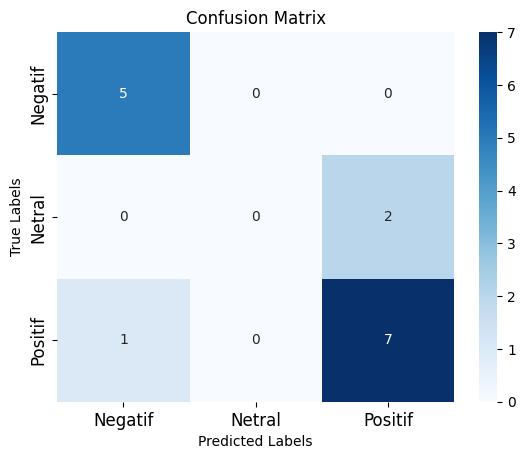

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten the predictions_place and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_place for pred in batch_pred]
y_true = [label for batch_label in true_labels_place for label in batch_label]

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g' )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

ticks = ['Negatif', 'Netral', 'Positif']
plt.xticks([0.5, 1.5, 2.5], ticks, fontsize=12)
plt.yticks([0.5, 1.5, 2.5], ticks, fontsize=12)

plt.show()

##Melakukan Klasifikasi Aspek Promotion

In [ ]:
from sklearn.model_selection import train_test_split

# Split data menjadi data train dan data test dengan rasio 80:20
train_df_promotion, test_df_promotion = train_test_split(df_promotion, test_size=0.2)

# Split data menjadi data test dan validation test dengan rasio 50:50
test_df_promotion, val_df_promotion = train_test_split(test_df_promotion, test_size=0.5)

In [ ]:
print(len(df_promotion))

print(len(train_df_promotion))
print(len(test_df_promotion))
print(len(val_df_promotion))

111
88
11
12


In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

# Kolom sentiment yang telah di ubah ke numerik
label = 'sentiment'

# Membuat dataset untuk training aspek promotion
train_promotion_input_ids = torch.cat(train_df_promotion['input_ids'].tolist(), dim=0)
train_promotion_attention_mask = torch.cat(train_df_promotion['attention_mask'].tolist(), dim=0)
train_promotion_sentiment_label = torch.tensor(train_df_promotion[label].values)

train_promotion_dataset = TensorDataset(train_promotion_input_ids, train_promotion_attention_mask, train_promotion_sentiment_label)

# Membuat dataset untuk validasi aspek promotion
val_promotion_input_ids = torch.cat(val_df_promotion['input_ids'].tolist(), dim=0)
val_promotion_attention_mask = torch.cat(val_df_promotion['attention_mask'].tolist(), dim=0)
val_promotion_sentimen_label = torch.tensor(val_df_promotion[label].values)

val_promotion_dataset = TensorDataset(val_promotion_input_ids, val_promotion_attention_mask, val_promotion_sentimen_label)

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Menginisialisasi model BERT Bahasa Indonesia untuk klasifikasi teks
model4 = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p2',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

# Menentukan optimizer dan scheduler untuk mengatur learning rate
optimizer = AdamW(model4.parameters(), lr=learning_rate, eps=eps)
train_promotion_dataloader = DataLoader(train_promotion_dataset, sampler=RandomSampler(train_promotion_dataset), batch_size=batch_size)
val_promotion_dataloader = DataLoader(val_promotion_dataset, sampler=SequentialSampler(val_promotion_dataset), batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_promotion_dataloader))
total_steps = len(train_promotion_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 3


In [ ]:
# Fungsi untuk mengkalkulasikan jumlah akurasi
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
#Fungsi untuk waktu yang digunakan model dalam proses training
def format_time(elapsed):

    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import random
import numpy as np

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    #Training Data
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model4.train()

    # For each batch of training data...
    for step, batch in enumerate(train_promotion_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_promotion_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model4.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # token_type_ids is same as the "segment ids", which differentiates
        # sentence 1 and 2 in sentence-pair tasks
        outputs = model4(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.

        loss = outputs[0]

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model4.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_promotion_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Validation Data
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model4.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_promotion_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model4(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_promotion_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_promotion_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.04
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.01
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.95
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.94
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.86
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.88
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.77
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.84
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.73
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.83
  Validation took: 0:00:00

Training complete!


In [ ]:
import pandas as pd


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,1.042983,1.007868,0.500000,0:00:01,0:00:00
2,0.947935,0.936268,0.666667,0:00:01,0:00:00
3,0.856915,0.879791,0.666667,0:00:01,0:00:00
4,0.766964,0.841683,0.750000,0:00:01,0:00:00
5,0.731889,0.830865,0.750000,0:00:01,0:00:00


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler

label = 'sentiment'

# Membuat dataset untuk training
test_promotion_input_ids = torch.cat(test_df_promotion['input_ids'].tolist(), dim=0)
test_promotion_attention_mask = torch.cat(test_df_promotion['attention_mask'].tolist(), dim=0)
test_promotion_sentiment_label = torch.tensor(test_df_promotion[label].values)


# Create the DataLoader.
prediction_promotion_data = TensorDataset(test_promotion_input_ids, test_promotion_attention_mask, test_promotion_sentiment_label)
prediction_promotion_sampler = SequentialSampler(prediction_promotion_data)
prediction_promotion_dataloader = DataLoader(prediction_promotion_data, sampler=prediction_promotion_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels aspect for {:,} test sentences...'.format(len(test_promotion_input_ids)))

# Put model in evaluation mode
model4.eval()

# Tracking variables
predictions_promotion , true_labels_promotion = [], []

# Predict
for batch in prediction_promotion_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions_promotion
      outputs = model4(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions_promotion and true labels
  predictions_promotion.append(logits)
  true_labels_promotion.append(label_ids)

print('    DONE.')

Predicting labels aspect for 11 test sentences...
    DONE.


In [ ]:
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions_promotion)):
  total_accuracy += flat_accuracy(predictions_promotion[batch_num], true_labels_promotion[batch_num])

total_accuracy = total_accuracy/len(predictions_promotion)*100
print('Accuracy on test dataset:', total_accuracy)


Accuracy on test dataset: 72.72727272727273


In [ ]:
print(len(test_df_promotion))
print(test_df_promotion["sentiment"].value_counts())

11
2    7
1    2
0    2
Name: sentiment, dtype: int64


In [ ]:
from sklearn.metrics import classification_report

# Flatten the predictions_promotion and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_promotion for pred in batch_pred]
y_true = [label for batch_label in true_labels_promotion for label in batch_label]

# Calculate accuracy
total_accuracy = 0
for batch_num in range(len(predictions_promotion)):
  total_accuracy += flat_accuracy(predictions_promotion[batch_num], true_labels_promotion[batch_num])
total_accuracy = total_accuracy/len(predictions_promotion)*100
print('Accuracy on test dataset aspect promotion:', total_accuracy)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=['Negatif', 'Netral', 'Positif'])
print('Classification Report Aspect promotion :\n', report)

Accuracy on test dataset aspect promotion: 72.72727272727273
Classification Report Aspect promotion :
               precision    recall  f1-score   support

     Negatif       0.50      1.00      0.67         2
      Netral       0.00      0.00      0.00         2
     Positif       0.86      0.86      0.86         7

    accuracy                           0.73        11
   macro avg       0.45      0.62      0.51        11
weighted avg       0.64      0.73      0.67        11



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


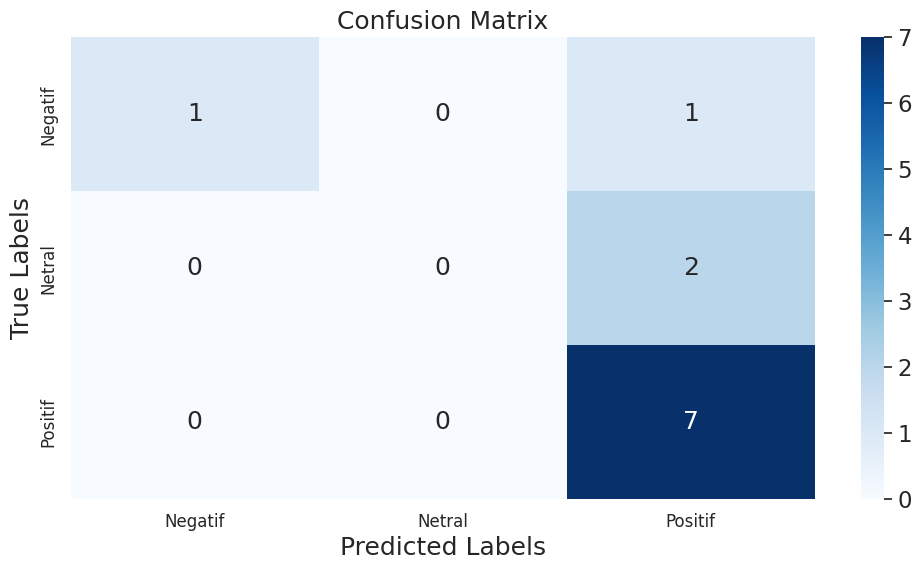

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten the predictions_promotion and true labels
y_pred = [np.argmax(pred) for batch_pred in predictions_promotion for pred in batch_pred]
y_true = [label for batch_label in true_labels_promotion for label in batch_label]

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g' )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

ticks = ['Negatif', 'Netral', 'Positif']
plt.xticks([0.5, 1.5, 2.5], ticks, fontsize=12)
plt.yticks([0.5, 1.5, 2.5], ticks, fontsize=12)

plt.show()